In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from mmd import MMDWAE

import matplotlib.pyplot as plt

In [ ]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(tuple([tensor.shape[0]] + self.size))
    
class NiNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride, pad, type_='down'):
        super(NiNBlock, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel = kernel 
        self.stride = stride
        self.pad = pad
        
        if type_ == 'down':
            self.block = nn.Sequential(nn.Conv2d(self.in_ch, self.out_ch, self.kernel, self.stride, 
                                                 self.pad, bias=False),
                                       nn.BatchNorm2d(self.out_ch),
                                       nn.ReLU(True))
        else:
            self.block = nn.Sequential(nn.ConvTranspose2d(self.in_ch, self.out_ch, self.kernel, self.stride, 
                                                 self.pad, bias=False),
                                       nn.BatchNorm2d(self.out_ch),
                                       nn.ReLU(True))
        
    def forward(self, x):
        return self.block(x)
    

class Encoder(nn.Module):
    def __init__(self, z_dim, num_channels, last_dim):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.num_channels = num_channels
        self.last_dim = last_dim
        
        self.net = nn.Sequential(NiNBlock(self.num_channels, 128, 4, 2, 1, 'down'),
                                 NiNBlock(128, 256, 4, 2, 1, 'down'),
                                 NiNBlock(256, 512, 4, 2, 1, 'down'),
                                 NiNBlock(512, 1024, 4, 2, 1, 'down'),
                                 View([-1]),
                                 nn.Linear(1024 * last_dim * last_dim, self.z_dim),)
        
    def forward(self, x):
        return self.net(x)
    

class Decoder(nn.Module):
    def __init__(self, z_dim, num_channels, first_dim):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.num_channels = num_channels
        self.first_dim = first_dim

        self.net = nn.Sequential(nn.Linear(self.z_dim, 1024 * self.first_dim * self.first_dim),
                                 View([1024, self.first_dim, self.first_dim]),     
                                 NiNBlock(1024, 512, 4, 2, 1, 'up'),
                                 NiNBlock(512, 256, 4, 2, 1, 'up'),
                                 nn.ConvTranspose2d(256, self.num_channels, 3, 1, 1),
                                )
    def forward(self, x):
        return self.net(x)

In [2]:
torchvision.datasets.MNIST(
    root='./',
    download=True
)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./',
                               train=True, 
                               download=False,
                               transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))]),
                              ),
    batch_size=batch_size, shuffle=True
)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /root/data/sdc/WAE/
    Transforms (if any): None
    Target Transforms (if any): None

In [6]:
nc = 1
z_dim = 10
encoder = Encoder(z_dim, nc, 1)
decoder = Decoder(z_dim, nc, 7)

In [10]:
def sample_latent_prior(batch_size, device):
    return torch.normal(torch.zeros(batch_size, z_dim), torch.ones(batch_size, z_dim)).to(device)

def cost(Y_true, Y_pred):
    return torch.nn.functional.mse_loss(Y_pred, Y_true)

def kernel(z1, z2):

    z11 = z1.unsqueeze(1).repeat(1, z2.size(0), 1)
    z22 = z2.unsqueeze(0).repeat(z1.size(0), 1, 1)
    
    C = 1

    kernel_matrix = C/(1e-9+C+(z11-z22).pow(2).sum(2))
    kernel_sum = kernel_matrix.sum()

    return kernel_sum

In [ ]:
device = torch.device("cuda:"+str(1) if torch.cuda.is_available() else "cpu")

nc = 1
z_dim = 10
encoder = Encoder(z_dim, nc, 1)
decoder = Decoder(z_dim, nc, 7)

optimizer = torch.optim.Adam(
            list(encoder.parameters()) + list(decoder.parameters()),
            lr=1e-4)

In [12]:
mmd = MMDWAE(cost=cost, decoder=decoder, encoder=encoder, device=device, lamda_coeff=1, kernel=kernel,
       sample_latent_prior=sample_latent_prior, trainloader=train_loader, optimizer=optimizer)

mmd.train(10)

In [14]:
sample = mmd.sample(10)

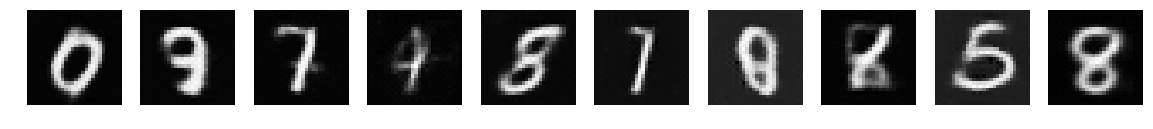

In [25]:
plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(sample.data.cpu().numpy()[i][0], cmap='gray')
    plt.axis('off')